In [10]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import precision_score, recall_score, jaccard_score
from scipy.spatial.distance import directed_hausdorff
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random


In [11]:
class Config:
    img_size = 224
    batch_size = 8
    lr = 5e-5
    epochs = 50
    img_dir = "D:/Leko/medical_model/task2/data/images"  # 图像路径
    mask_dir = "D:/Leko/medical_model/task2/data/masks"   # 掩码路径
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    saved_model_dir = "D:\\Leko\\medical_model\\task2\\model"
    best_model_name = "UnetppResnet34.pth"

In [12]:
class MedicalSegmentationDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir, transform=None):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        name, _ = os.path.splitext(img_name)   
        mask_name = f"{name}_mask.png"          
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)

        return image, mask


In [13]:
def dice_loss(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    intersection = (preds * targets).sum(dim=(2,3))
    union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def plot_history(history):
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history['val_dice'], label='Val Dice')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.legend()
    plt.title('Validation Metrics')
    plt.grid(True)

    plt.show()

def save_metrics_to_csv(history, save_path="D:/Leko/medical_model/task2/modeltraining_metrics.csv"):
    df = pd.DataFrame({
        "Train Loss": history["train_loss"],
        "Val Loss": history["val_loss"],
        "Val Dice": history["val_dice"],
        "Val IoU": history["val_iou"],
    })
    df.to_csv(save_path, index=False)
    print(f" 训练指标已保存到 {save_path}")


def apply_cutmix_mixup(imgs, masks, alpha=1.0, cutmix_prob=0.5, mixup_prob=0.5):
    batch_size = imgs.size(0)
    
    # --- 随机决定使用哪种增强 ---
    rand_val = random.random()
    
    if rand_val < cutmix_prob:
        lam = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(batch_size).to(imgs.device)
        
        bbx1, bby1, bbx2, bby2 = rand_bbox(imgs.size(), lam)
        imgs[:, :, bbx1:bbx2, bby1:bby2] = imgs[rand_index, :, bbx1:bbx2, bby1:bby2]
        masks[:, :, bbx1:bbx2, bby1:bby2] = masks[rand_index, :, bbx1:bbx2, bby1:bby2]
        
    elif rand_val < cutmix_prob + mixup_prob:
        lam = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(batch_size).to(imgs.device)
        
        imgs = imgs * lam + imgs[rand_index] * (1 - lam)
        masks = masks * lam + masks[rand_index] * (1 - lam)

    else:
        pass

    return imgs, masks

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int32(W * cut_rat)
    cut_h = np.int32(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2



In [14]:
def show_samples(dataset, num_samples=4, title="Samples"):
    plt.figure(figsize=(12, num_samples * 3))

    for i in range(num_samples):
        img, mask = dataset[i]
        img = img.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
        mask = mask.squeeze().cpu().numpy()       # (1, H, W) -> (H, W)

        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = (img * std + mean).clip(0, 1)

        plt.subplot(num_samples, 2, i*2 + 1)
        plt.imshow(img)
        plt.title(f"{title} Image {i+1}")
        plt.axis("off")

        plt.subplot(num_samples, 2, i*2 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"{title} Mask {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

训练集数量: 240
验证集数量: 30


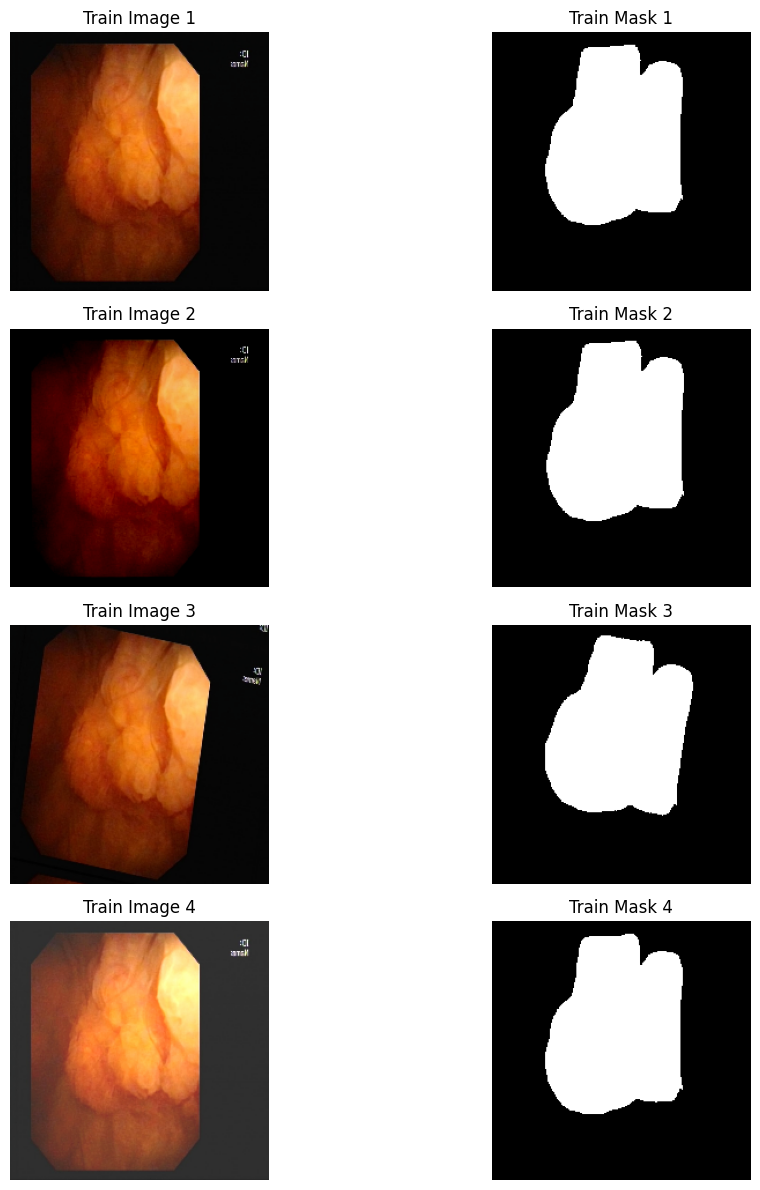

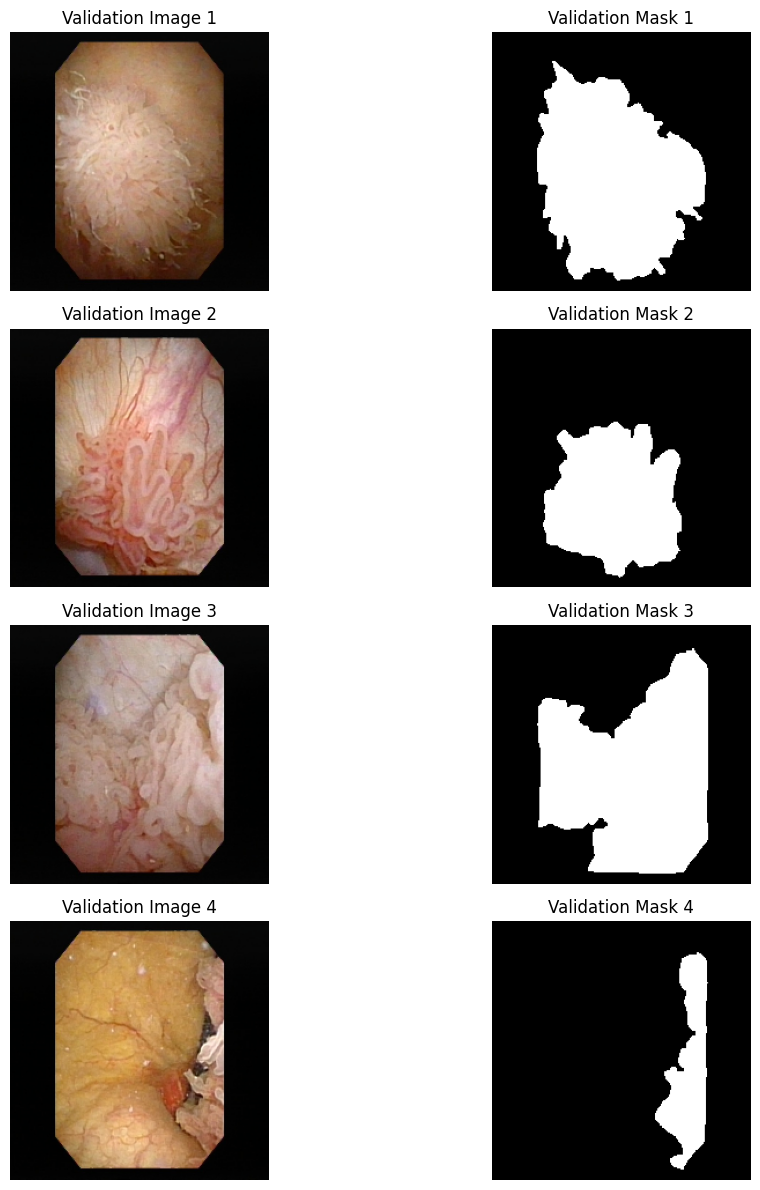

In [ ]:
all_images = sorted([
    f for f in os.listdir(Config.img_dir)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])

# 手动前240张为训练集，其余为验证集
train_files = all_images[:240]
val_files = all_images[240:]

print(f"训练集数量: {len(train_files)}")
print(f"验证集数量: {len(val_files)}")


# 增强
train_transform = A.Compose([
    A.Resize(Config.img_size, Config.img_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(Config.img_size, Config.img_size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# 加载
train_dataset = MedicalSegmentationDataset(train_files, Config.img_dir, Config.mask_dir, train_transform)
val_dataset = MedicalSegmentationDataset(val_files, Config.img_dir, Config.mask_dir, val_transform)

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False)

show_samples(train_dataset, num_samples=4, title="Train")
show_samples(val_dataset, num_samples=4, title="Validation")


c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch 1: Val Dice=0.5441, Val IoU=0.4241, Val Loss=1.0624
保存了新的最优模型


Epoch 2/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/50: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Epoch 2: Val Dice=0.6040, Val IoU=0.4915, Val Loss=0.9448
保存了新的最优模型


Epoch 3/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/50: 100%|██████████| 30/30 [00:10<00:00,  2.83it/s]


Epoch 3: Val Dice=0.6757, Val IoU=0.5710, Val Loss=0.7655
保存了新的最优模型


Epoch 4/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/50: 100%|██████████| 30/30 [00:10<00:00,  2.81it/s]


Epoch 4: Val Dice=0.7098, Val IoU=0.6182, Val Loss=0.7110
保存了新的最优模型


Epoch 5/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch 5: Val Dice=0.7416, Val IoU=0.6515, Val Loss=0.6674
保存了新的最优模型


Epoch 6/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch 6: Val Dice=0.7483, Val IoU=0.6530, Val Loss=0.6434
保存了新的最优模型


Epoch 7/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/50: 100%|██████████| 30/30 [00:10<00:00,  2.82it/s]


Epoch 7: Val Dice=0.7320, Val IoU=0.6429, Val Loss=0.6350


Epoch 8/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/50: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


Epoch 8: Val Dice=0.7657, Val IoU=0.6663, Val Loss=0.5928
保存了新的最优模型


Epoch 9/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/50: 100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


Epoch 9: Val Dice=0.7570, Val IoU=0.6766, Val Loss=0.5835


Epoch 10/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/50: 100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


Epoch 10: Val Dice=0.7505, Val IoU=0.6659, Val Loss=0.5833


Epoch 11/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch 11: Val Dice=0.7578, Val IoU=0.6738, Val Loss=0.5702


Epoch 12/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/50: 100%|██████████| 30/30 [00:10<00:00,  2.94it/s]


Epoch 12: Val Dice=0.7620, Val IoU=0.6773, Val Loss=0.5584


Epoch 13/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/50: 100%|██████████| 30/30 [00:10<00:00,  2.95it/s]


Epoch 13: Val Dice=0.7641, Val IoU=0.6777, Val Loss=0.5393


Epoch 14/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/50: 100%|██████████| 30/30 [00:10<00:00,  2.95it/s]


Epoch 14: Val Dice=0.7644, Val IoU=0.6792, Val Loss=0.5389


Epoch 15/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/50: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Epoch 15: Val Dice=0.7766, Val IoU=0.6915, Val Loss=0.5133
保存了新的最优模型


Epoch 16/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch 16: Val Dice=0.7680, Val IoU=0.6720, Val Loss=0.5153


Epoch 17/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/50: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Epoch 17: Val Dice=0.7585, Val IoU=0.6708, Val Loss=0.5079


Epoch 18/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/50: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Epoch 18: Val Dice=0.7709, Val IoU=0.6736, Val Loss=0.4972


Epoch 19/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch 19: Val Dice=0.7684, Val IoU=0.6815, Val Loss=0.4799


Epoch 20/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/50: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Epoch 20: Val Dice=0.7583, Val IoU=0.6773, Val Loss=0.5000


Epoch 21/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 21/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch 21: Val Dice=0.7737, Val IoU=0.6862, Val Loss=0.4819


Epoch 22/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 22/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch 22: Val Dice=0.7667, Val IoU=0.6723, Val Loss=0.4857


Epoch 23/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 23/50: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Epoch 23: Val Dice=0.7817, Val IoU=0.6960, Val Loss=0.4599
保存了新的最优模型


Epoch 24/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 24/50: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Epoch 24: Val Dice=0.7584, Val IoU=0.6637, Val Loss=0.5123


Epoch 25/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 25/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch 25: Val Dice=0.7721, Val IoU=0.6753, Val Loss=0.4639


Epoch 26/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 26/50: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Epoch 26: Val Dice=0.7885, Val IoU=0.6850, Val Loss=0.4539
保存了新的最优模型


Epoch 27/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 27/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch 27: Val Dice=0.7786, Val IoU=0.6810, Val Loss=0.4543


Epoch 28/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 28/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch 28: Val Dice=0.7886, Val IoU=0.6888, Val Loss=0.4461
保存了新的最优模型


Epoch 29/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 29/50: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Epoch 29: Val Dice=0.7719, Val IoU=0.6787, Val Loss=0.4541


Epoch 30/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 30/50: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Epoch 30: Val Dice=0.7601, Val IoU=0.6628, Val Loss=0.4715


Epoch 31/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 31/50: 100%|██████████| 30/30 [00:10<00:00,  2.83it/s]


Epoch 31: Val Dice=0.7531, Val IoU=0.6551, Val Loss=0.4841


Epoch 32/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 32/50: 100%|██████████| 30/30 [00:10<00:00,  2.83it/s]


Epoch 32: Val Dice=0.7643, Val IoU=0.6697, Val Loss=0.4658


Epoch 33/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 33/50: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Epoch 33: Val Dice=0.7856, Val IoU=0.6840, Val Loss=0.4364


Epoch 34/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 34/50: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Epoch 34: Val Dice=0.7644, Val IoU=0.6669, Val Loss=0.4452


Epoch 35/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 35/50: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Epoch 35: Val Dice=0.7720, Val IoU=0.6745, Val Loss=0.4530


Epoch 36/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 36/50: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Epoch 36: Val Dice=0.7727, Val IoU=0.6721, Val Loss=0.4458


Epoch 37/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 37/50: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Epoch 37: Val Dice=0.7623, Val IoU=0.6597, Val Loss=0.4634


Epoch 38/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_4684\531265019.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 38/50: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Epoch 38: Val Dice=0.7683, Val IoU=0.6704, Val Loss=0.4520
Early Stopping triggered at Epoch 38


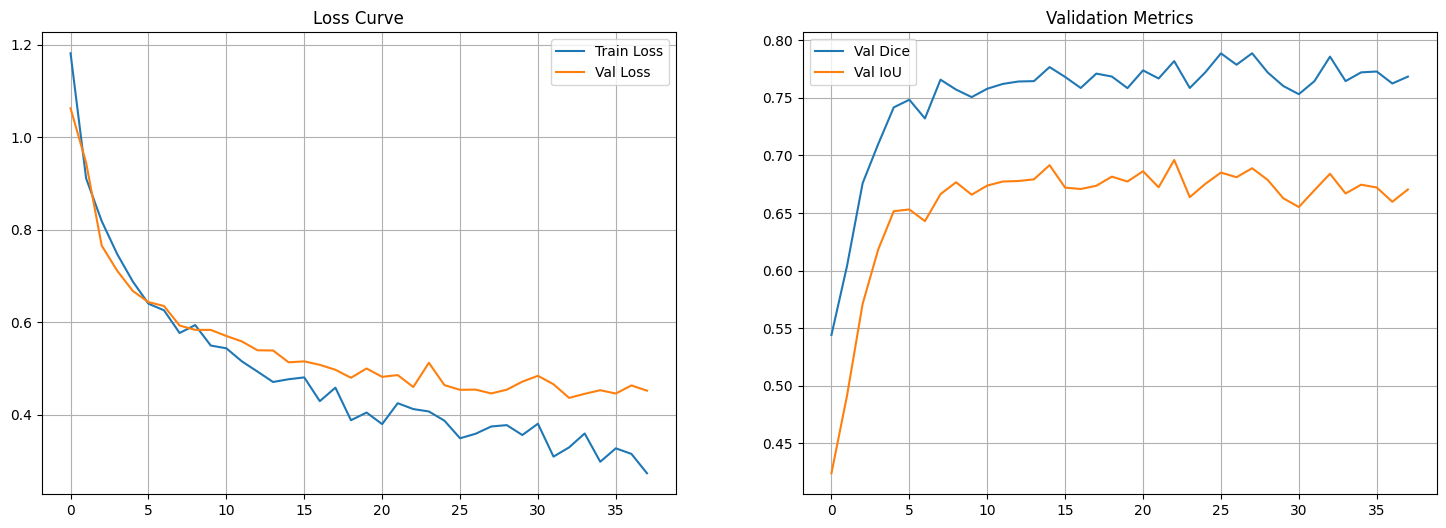

 训练指标已保存到 D:/Leko/medical_model/task2/modeltraining_metrics.csv
 最佳Dice分数: 0.7886


In [16]:

model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(Config.device)


optimizer = torch.optim.Adam(model.parameters(), lr=Config.lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
scaler = GradScaler()


history = {"train_loss": [], "val_loss": [], "val_dice": [], "val_iou": []}

best_dice = 0
patience = 10
no_improve = 0

for epoch in range(Config.epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.epochs}")
    #cutmix_prob = min(0.5 + 0.01 * epoch, 0.8)  # 每个epoch增加1%，最高到80%
    for imgs, masks in loop:
        imgs, masks = imgs.to(Config.device), masks.to(Config.device).float()
        imgs, masks = apply_cutmix_mixup(imgs, masks, alpha=1.0, cutmix_prob=0.5, mixup_prob=0.5)
        optimizer.zero_grad()

        with autocast():
            preds = model(imgs)
            bce = F.binary_cross_entropy_with_logits(preds, masks)
            dice = dice_loss(preds, masks)
            loss = bce + 0.7 * dice

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    # 验证阶段
    model.eval()
    val_loss = 0
    all_preds, all_gts = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(Config.device), masks.to(Config.device).float()
            preds = model(imgs)
            bce = F.binary_cross_entropy_with_logits(preds, masks)
            dice = dice_loss(preds, masks)
            val_loss += (bce + 0.7 * dice).item()

            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            all_preds.extend(preds.cpu().numpy().reshape(preds.shape[0], -1))
            all_gts.extend(masks.cpu().numpy().reshape(masks.shape[0], -1))

    all_preds = np.array(all_preds)
    all_gts = np.array(all_gts)

    dice_scores = (2 * (all_preds * all_gts).sum(axis=1) + 1e-8) / ((all_preds + all_gts).sum(axis=1) + 1e-8)
    avg_val_dice = dice_scores.mean()
    avg_val_iou = jaccard_score(all_gts.flatten(), all_preds.flatten(), zero_division=0)
    val_avg_loss = val_loss / len(val_loader)

    history["train_loss"].append(total_loss / len(train_loader))
    history["val_loss"].append(val_avg_loss)
    history["val_dice"].append(avg_val_dice)
    history["val_iou"].append(avg_val_iou)

    print(f"Epoch {epoch+1}: Val Dice={avg_val_dice:.4f}, Val IoU={avg_val_iou:.4f}, Val Loss={val_avg_loss:.4f}")

    scheduler.step(val_avg_loss)


    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        os.makedirs(Config.saved_model_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(Config.saved_model_dir, "Unet+++Resnet34.pth"))
        print("保存了新的最优模型")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early Stopping triggered at Epoch {epoch+1}")
            break


plot_history(history)
save_metrics_to_csv(history, save_path="D:/Leko/medical_model/task2/modeltraining_metrics.csv")

print(f" 最佳Dice分数: {best_dice:.4f}")

C:\Users\15307\AppData\Local\Temp\ipykernel_4684\3988882474.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


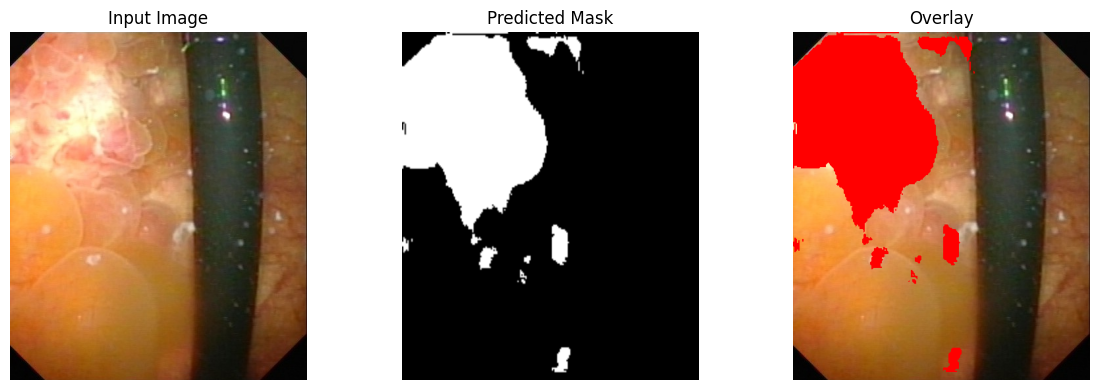

In [18]:

import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp


image_path = "D:/Leko/test2.jpg"
model_path = os.path.join(Config.saved_model_dir, "Unet+++Resnet34.pth") 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights=None,  # 加载自己训练的权重，不用再加载预训练
    in_channels=3,
    classes=1,
    activation=None
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

transform = A.Compose([
    A.Resize(Config.img_size, Config.img_size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
original_size = (image_rgb.shape[1], image_rgb.shape[0])  # 原始尺寸 (w, h)

augmented = transform(image=image_rgb)
input_tensor = augmented["image"].unsqueeze(0).to(device)

with torch.no_grad(), torch.cuda.amp.autocast():
    pred = model(input_tensor)
    pred_sigmoid = torch.sigmoid(pred)
    pred_mask = (pred_sigmoid > 0.5).float().squeeze().cpu().numpy()

pred_mask_resized = cv2.resize(pred_mask, original_size)


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_mask_resized, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
overlay = image_rgb.copy()
overlay[pred_mask_resized > 0.5] = [255, 0, 0]  # 将掩码区域涂红
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()
